### Import libraries and features 

In [1]:
import gc
import sys
import os 
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from CarPrice import *
%load_ext autoreload
%autoreload 2

### Import data and split into train and test 

In [4]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")

### garbage collect

In [5]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Generate a base model first 

In [6]:
base_model = ElasticNet(random_state=2020)

In [7]:
CarPrice_Linear = CarPrice(data,base_model)

In [9]:
X_train, X_test,y_train,y_test = CarPrice_Linear.data_split(1988,0.1)

In [10]:
CarPrice_Linear.regression_metrics(X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.552557,6584.231121,2136.678925
test,0.535786,6865.069706,1126.375198


### Base model predicts r2 score of ~0.55. Not terrible but a root mean squared error of 6800 for a used car price is quite terrible. Let's perform gridsearch to improve the results

### Key parameters

* alpha: default 1 
* l1__ratio: default 0.5 
* max_iter: default 1000
* tol: default 1e-5

In [11]:
params = {
    "alpha":[0.0005,0.005,0.05],
    "l1_ratio":[1,0],
    "max_iter":[1000,2000],
    "tol":[1e-4,5e-5]
}

In [13]:
CarPrice_Linear.param_search(params,X_train,y_train,V=0)

In [15]:
CarPrice_Linear.regression_metrics(X_train,y_train,X_test,y_test)

,r2_score,rmse,price_diff_abs_max
train,0.841081,3923.949957,1814.554403
test,0.823081,4238.119220,424.366361


In [ ]:
CarPrice_Linear.search_result

In [16]:
tuned_model = CarPrice_Linear.search_result.best_estimator_

### Better than before but 4000 is very high error as well. 

### Let's look at feature importances and which samples have bad results

### Coefficients and look for feature ranking

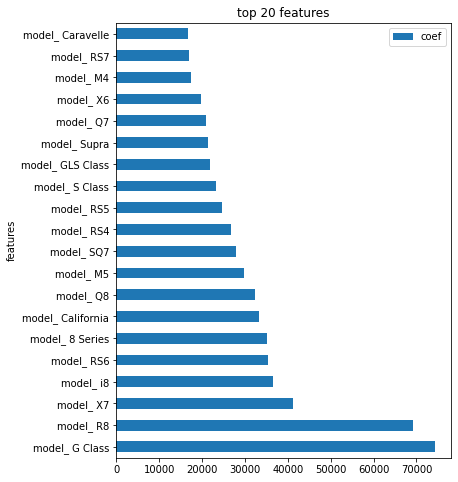

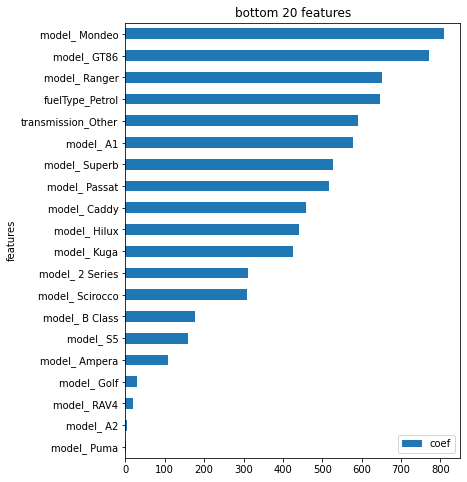

In [18]:
feature_table = CarPrice_Linear.linear_feature_importance(plot=True)

### Remove features with very low coef to see if it improve performance. 

* Remove 10 bottom features

In [23]:
CarPrice_Linear.removeFeatures(10)
X_train_trimmed,X_test_trimmed,y_train_trimmed,y_test_trimmed = CarPrice_Linear.data_split(1988,0.1)

In [25]:
CarPrice_Linear.regression_metrics(X_train_trimmed,y_train_trimmed,X_test_trimmed,y_test_trimmed)

,r2_score,rmse,price_diff_abs_max
train,0.841029,3924.601299,1811.689169
test,0.822917,4240.079744,426.196991


### Similar performance but with less features
### Look at examples where the price is way off 

In [29]:
price_diff_table = CarPrice_Linear.price_diff

### Looking at the features with 50 most difference price prediction

In [30]:
price_diff_table.head(50)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,model_ 8 Series,...,model_EcoSport,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,price_diff_pct,price_diff_abs
39336,1,5,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1811.689169,1811.689169
20061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1522.237396,1522.237396
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1221.135362,1221.135362
39978,1,5,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,935.865798,935.865798
71819,1,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,923.200152,923.200152
11984,1,0,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,869.690986,869.690986
77582,1,4,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,813.699230,813.699230
44309,1,5,4,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-800.566062,800.566062
44539,1,4,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-787.661749,787.661749
87481,0,4,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,762.882873,762.882873


### Looking at 50 best predicted cars

In [31]:
price_diff_table.tail(50)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,model_ 8 Series,...,model_EcoSport,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,price_diff_pct,price_diff_abs
23625,4,1,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-0.011299,0.011299
18205,3,2,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0.011092,0.011092
95823,3,3,4,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-0.011002,0.011002
34111,4,0,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0.010834,0.010834
38670,3,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.010748,0.010748
5942,3,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.010385,0.010385
5952,3,2,4,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.010385,0.010385
81675,3,3,4,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0.009871,0.009871
88407,3,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.009709,0.009709
36018,4,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.008839,0.008839


### Check overall how the predicted price versus actual price appear and if the residual is guassian

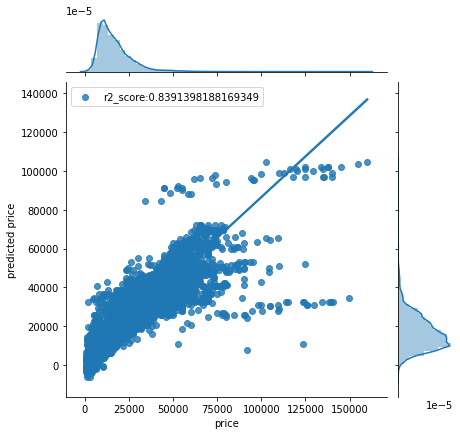

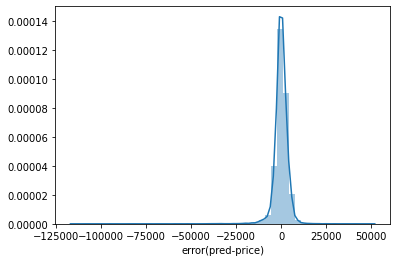

In [33]:
CarPrice_Linear.plot_pred_price

### summary:

* cars that are older tend to be harder to predict for the price especially if the mileage is low for the age of the car

### Overally not a bad first model:
* residuals are roughly gaussian 
* r2 score is 0.84
_____